In [50]:
# ipython kernel install --user --name=venv
import pandas as pd
import numpy as np
import requests
import json
from pandas import json_normalize
from functools import reduce
import matplotlib.pyplot as plt
from itables import show
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, mean_squared_error, r2_score
from sklearn.tree import export_graphviz
from scipy.stats import randint

In [2]:
CAMPINAS_CODE = "3509502"
SAO_PAULO_CODE = "3550308"
CAPELINHA_CODE = "3112307"
INDAIATUBA_CODE = "3520509"

In [3]:
def _get_county_pib_df(json_data):
    pib_municipios_ibge_json = json_data[0]["resultados"][0]["series"]
    pib_municipios_ibge_df = pd.json_normalize(pib_municipios_ibge_json)
    pib_municipios_ibge_df = pib_municipios_ibge_df.drop(['localidade.nivel.id', 'localidade.nivel.nome', "localidade.nome"], axis=1)
    return pib_municipios_ibge_df

In [4]:
# Build the table with county PIB

years = list(range(2013, 2022))
counties_pib_dfs = []

for year in years:
    print(f"Getting data for year {year}")
    county_pib_url = f"https://servicodados.ibge.gov.br/api/v3/agregados/5938/periodos/{year}/variaveis/37?localidades=N6[all]"
    response = requests.get(county_pib_url)

    if response.status_code == 200:
        data = response.json()
        print("Building dataframe...")
        counties_pib_dfs.append(_get_county_pib_df(data))
    else:
        print("Request failed with status code:", response.status_code)

print("Merging dataframes...")
complete_counties_pib = reduce(lambda df1,df2: pd.merge(df1,df2,on='localidade.id', how='outer'), counties_pib_dfs)

new_column_names = {'serie.{}'.format(year): 'pib_{}'.format(year) for year in years}
new_column_names["localidade.id"] = "county_id"
complete_counties_pib = complete_counties_pib.rename(columns=new_column_names)

print("Finished building the table with county PIB")

Getting data for year 2013
Building dataframe...
Getting data for year 2014


KeyboardInterrupt: 

In [5]:
display(complete_counties_pib)

,county_id,pib_2013,pib_2014,pib_2015,pib_2016,pib_2017,pib_2018,pib_2019,pib_2020,pib_2021
0,1100015,341325,377799,421300,478217,485374,498980,495775,570242,734469
1,1100023,1799853,1921532,2037799,2184346,2287910,2464704,2579278,2817331,3209761
2,1100031,96365,113477,116565,133342,138110,140503,139976,167153,238412
3,1100049,1433254,1660650,1794478,1947283,2082761,2175840,2261930,2518845,2792383
4,1100056,353270,392417,397736,408194,439245,470647,506494,600630,743037
...,...,...,...,...,...,...,...,...,...,...
5565,5222005,291919,302880,312348,373802,395861,449973,489265,559058,857968
5566,5222054,259422,275800,322298,351750,350839,339089,326519,419757,480173
5567,5222203,103233,90478,111229,138810,118639,108469,112209,126150,179899
5568,5222302,142970,138474,198935,210475,182203,179915,207994,217935,308013


In [6]:
display(complete_counties_pib[complete_counties_pib['county_id'] == SAO_PAULO_CODE])

,county_id,pib_2013,pib_2014,pib_2015,pib_2016,pib_2017,pib_2018,pib_2019,pib_2020,pib_2021
3829,3550308,582079726,621917372,653646991,683066697,698952189,714663604,763597808,746909330,828980608


# Dados do INEP

_O conceito técnico de abandono é diferente de evasão. Abandono quer dizer que o aluno deixa a escola num ano mas retorna no ano seguinte. Evasão significa que o aluno sai da escola e não volta mais para o sistema._

In [6]:
inep_data = pd.read_csv("master_data_2021_v3.csv", delimiter=";") 

# inep_data = pd.read_excel("master_data_2021.xlsx")
# display(inep_data)

filtered_data = inep_data[(inep_data['NO_CATEGORIA'] == 'Total') & (inep_data['NO_DEPENDENCIA'] == 'Total')]
# drop_columns = ["ED_BAS_CAT1",	"ED_BAS_CAT2",	"ED_BAS_CAT3",	"ED_BAS_CAT4",	"ED_BAS_CAT5",	"ED_BAS_CAT6",	"ED_BAS_CAT7",	"ED_BAS_CAT8",	"ED_BAS_CAT9"]
# filtered_data = filtered_data.drop(drop_columns, axis=1)


# display(filtered_data)

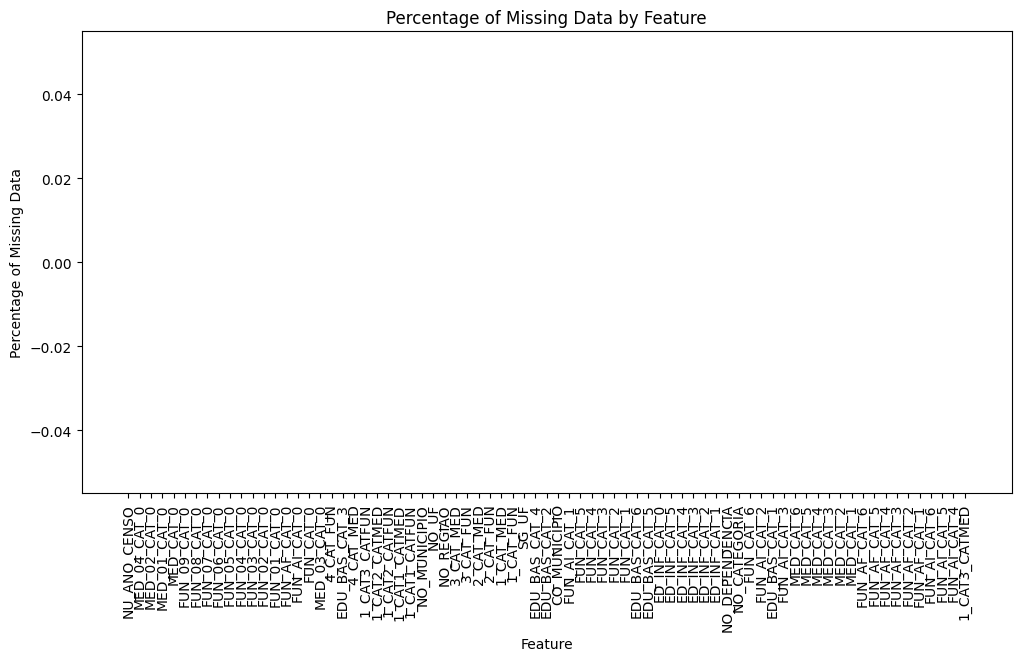

In [7]:
# Crie um DataFrame com as informações das features e a quantidade de dados faltantes
df_missing = pd.DataFrame({'Feature': filtered_data.columns, 'Missing': filtered_data.isnull().sum()})
df_missing['Percentage'] = (df_missing['Missing'] / len(filtered_data)) * 100

# Ordene o DataFrame pela porcentagem de dados faltantes em ordem decrescente
df_missing = df_missing.sort_values('Percentage', ascending=False)

# display(df_missing)

# Crie o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(df_missing['Feature'], df_missing['Percentage'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Percentage of Missing Data')
plt.title('Percentage of Missing Data by Feature')
plt.show()


In [8]:
display(filtered_data.dtypes)
column_types = filtered_data.dtypes.value_counts()
print(column_types)


NU_ANO_CENSO        int64
CO_MUNICIPIO        int64
NO_CATEGORIA       object
NO_DEPENDENCIA     object
ED_INF_CAT_1      float64
                   ...   
1_CAT1_CATMED     float64
1_CAT2_CATFUN     float64
1_CAT2_CATMED     float64
1_CAT3_CATFUN     float64
1_CAT3_CATMED     float64
Length: 75, dtype: object

float64    66
object      7
int64       2
Name: count, dtype: int64


In [9]:
ABANDONO_COLUMN_FUN = "3_CAT_FUN"
ABANDONO_COLUMN_MED ="3_CAT_MED"
EVASAO_COLUMN_FUN = "1_CAT3_CATFUN"
EVASAO_COLUMN_MED = "1_CAT3_CATMED"

In [10]:
colunas_interesse = ["ABANDONO_COLUMN_FUN", "ABANDONO_COLUMN_MED", "EVASAO_COLUMN_FUN", "EVASAO_COLUMN_MED"]

filtered_data.rename(columns={
    '3_CAT_FUN': 'ABANDONO_COLUMN_FUN', 
    '3_CAT_MED': 'ABANDONO_COLUMN_MED', 
    '1_CAT3_CATFUN': 'EVASAO_COLUMN_FUN', 
    '1_CAT3_CATMED': 'EVASAO_COLUMN_MED'
    }, inplace=True)

for column in colunas_interesse:
    filtered_data[column] = filtered_data[column].astype(float)

In [11]:

# Colunas de interesse
colunas_interesse = ["ABANDONO_COLUMN_FUN", "ABANDONO_COLUMN_MED", "EVASAO_COLUMN_FUN", "EVASAO_COLUMN_MED"]

for column in colunas_interesse:
    print(f'Coluna: {column}')
    print("Mean: ", filtered_data[column].mean())
    print("Std: ", filtered_data[column].std())
    print("Mode: ", filtered_data[column].mode())
    print("Max: ", filtered_data[column].max())
    print("Min: ", filtered_data[column].min())
    print("===============================")


Coluna: ABANDONO_COLUMN_FUN
Mean:  0.2745736434108528
Std:  0.4293267294364507
Mode:  0    0.0
Name: ABANDONO_COLUMN_FUN, dtype: float64
Max:  3.0
Min:  0.0
Coluna: ABANDONO_COLUMN_MED
Mean:  2.449147286821706
Std:  2.9111298608585336
Mode:  0    0.0
Name: ABANDONO_COLUMN_MED, dtype: float64
Max:  16.7
Min:  0.0
Coluna: EVASAO_COLUMN_FUN
Mean:  0.7117829457364341
Std:  0.5413785738904955
Mode:  0    0.6
Name: EVASAO_COLUMN_FUN, dtype: float64
Max:  5.3
Min:  0.0
Coluna: EVASAO_COLUMN_MED
Mean:  2.8288372093023257
Std:  2.184425258032439
Mode:  0    0.0
Name: EVASAO_COLUMN_MED, dtype: float64
Max:  13.3
Min:  0.0


In [12]:
show(filtered_data[["CO_MUNICIPIO", "ABANDONO_COLUMN_MED", "EVASAO_COLUMN_MED"]])


In [13]:
display(filtered_data.query(f"ABANDONO_COLUMN_MED > EVASAO_COLUMN_MED"))

,NU_ANO_CENSO,CO_MUNICIPIO,NO_CATEGORIA,NO_DEPENDENCIA,ED_INF_CAT_1,ED_INF_CAT_2,ED_INF_CAT_3,ED_INF_CAT_4,ED_INF_CAT_5,ED_INF_CAT_0,...,ABANDONO_COLUMN_MED,NO_REGIAO,NO_UF,NO_MUNICIPIO,1_CAT1_CATFUN,1_CAT1_CATMED,1_CAT2_CATFUN,1_CAT2_CATMED,EVASAO_COLUMN_FUN,EVASAO_COLUMN_MED
2,2021,3500303,Total,Total,90.1,0.0,8.9,0.0,1.0,15.9,...,4.8,Sudeste,SP,Aguaí,98.9,95.3,0.5,1.6,0.4,0.9
3,2021,3500402,Total,Total,54.8,0.0,41.9,0.0,3.3,17.2,...,6.3,Sudeste,SP,Águas da Prata,99.4,97.5,0.2,0.8,0.4,1.7
5,2021,3500550,Total,Total,44.6,0.0,55.4,0.0,0.0,12.3,...,4.2,Sudeste,SP,Águas de Santa Bárbara,99.3,97.5,0.5,1.0,0.2,1.5
7,2021,3500709,Total,Total,91.0,0.0,2.9,0.0,6.1,15.8,...,8.6,Sudeste,SP,Agudos,98.4,96.5,0.7,1.5,0.9,1.9
9,2021,3500808,Total,Total,92.3,0.0,7.7,0.0,0.0,19.4,...,8.9,Sudeste,SP,Alfredo Marcondes,98.4,95.0,1.3,2.5,0.3,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,2021,3556354,Total,Total,66.7,0.0,21.2,0.0,12.1,15.1,...,14.9,Sudeste,SP,Vargem,97.5,95.6,1.6,0.7,0.7,3.7
633,2021,3556453,Total,Total,63.3,0.0,26.6,0.0,10.1,14.2,...,6.2,Sudeste,SP,Vargem Grande Paulista,98.9,96.7,0.6,0.6,0.5,1.7
634,2021,3556503,Total,Total,66.3,0.0,26.3,0.1,7.3,12.9,...,7.2,Sudeste,SP,Várzea Paulista,99.1,97.8,0.3,0.5,0.6,1.5
640,2021,3557006,Total,Total,49.7,0.0,21.8,0.8,27.7,18.9,...,2.5,Sudeste,SP,Votorantim,99.1,95.8,0.3,1.4,0.4,2.3


In [14]:
trainning_df = filtered_data.drop(["NU_ANO_CENSO","CO_MUNICIPIO","NO_CATEGORIA","NO_DEPENDENCIA","NO_REGIAO", "NO_UF"], axis=1)
display(trainning_df)


label_encoder = LabelEncoder()
x_categorical = trainning_df.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
x_numerical = trainning_df.select_dtypes(exclude=['object']).values
x = pd.concat([pd.DataFrame(x_numerical), x_categorical], axis=1).values


,ED_INF_CAT_1,ED_INF_CAT_2,ED_INF_CAT_3,ED_INF_CAT_4,ED_INF_CAT_5,ED_INF_CAT_0,EDU_BAS_CAT_5,EDU_BAS_CAT_6,FUN_CAT_1,FUN_CAT_2,...,2_CAT_MED,ABANDONO_COLUMN_FUN,ABANDONO_COLUMN_MED,NO_MUNICIPIO,1_CAT1_CATFUN,1_CAT1_CATMED,1_CAT2_CATFUN,1_CAT2_CATMED,EVASAO_COLUMN_FUN,EVASAO_COLUMN_MED
0,66.2,0.0,20.4,0.0,13.4,15.0,0.0,0.0,27.6,7.6,...,0.5,0.3,0.5,Adamantina,99.7,95.8,0.1,1.4,0.2,0.6
1,74.1,0.0,25.9,0.0,0.0,13.0,0.0,0.0,33.3,12.8,...,0.0,0.0,2.2,Adolfo,98.4,97.0,1.0,0.8,0.6,2.2
2,90.1,0.0,8.9,0.0,1.0,15.9,0.0,7.7,28.6,5.6,...,2.3,0.1,4.8,Aguaí,98.9,95.3,0.5,1.6,0.4,0.9
3,54.8,0.0,41.9,0.0,3.3,17.2,0.0,0.0,26.9,15.4,...,9.2,1.1,6.3,Águas da Prata,99.4,97.5,0.2,0.8,0.4,1.7
4,91.9,0.0,5.9,0.7,1.5,13.0,5.3,5.1,18.5,8.6,...,2.4,0.1,1.0,Águas de Lindóia,91.8,91.4,6.0,5.1,1.5,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,49.7,0.0,21.8,0.8,27.7,18.9,2.4,1.2,14.7,26.3,...,0.9,0.4,2.5,Votorantim,99.1,95.8,0.3,1.4,0.4,2.3
641,65.2,0.0,32.6,0.0,2.2,18.2,0.0,1.6,16.5,17.7,...,1.2,0.1,0.4,Votuporanga,98.8,96.0,0.7,1.5,0.5,2.3
642,90.0,0.0,0.0,0.0,10.0,9.4,33.3,0.0,26.0,7.4,...,0.0,0.0,0.0,Zacarias,99.1,100.0,0.0,0.0,0.9,0.0
643,41.4,0.0,55.7,0.0,2.9,17.5,8.3,0.0,17.0,6.4,...,0.6,0.4,4.1,Chavantes,99.1,88.3,0.3,5.5,0.5,2.6


In [82]:
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

y = trainning_df["EVASAO_COLUMN_MED"].values  # Target variable
# Fit the regressor with x and y data
regressor.fit(x_numerical, y)


/home/cristiano/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

In [83]:
# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score
 
# Access the OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions = regressor.predict(x_numerical)
 
# Evaluating the model
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.9728282370425053
Mean Squared Error: 0.0038894573643410936
R-squared: 0.9991836272809209


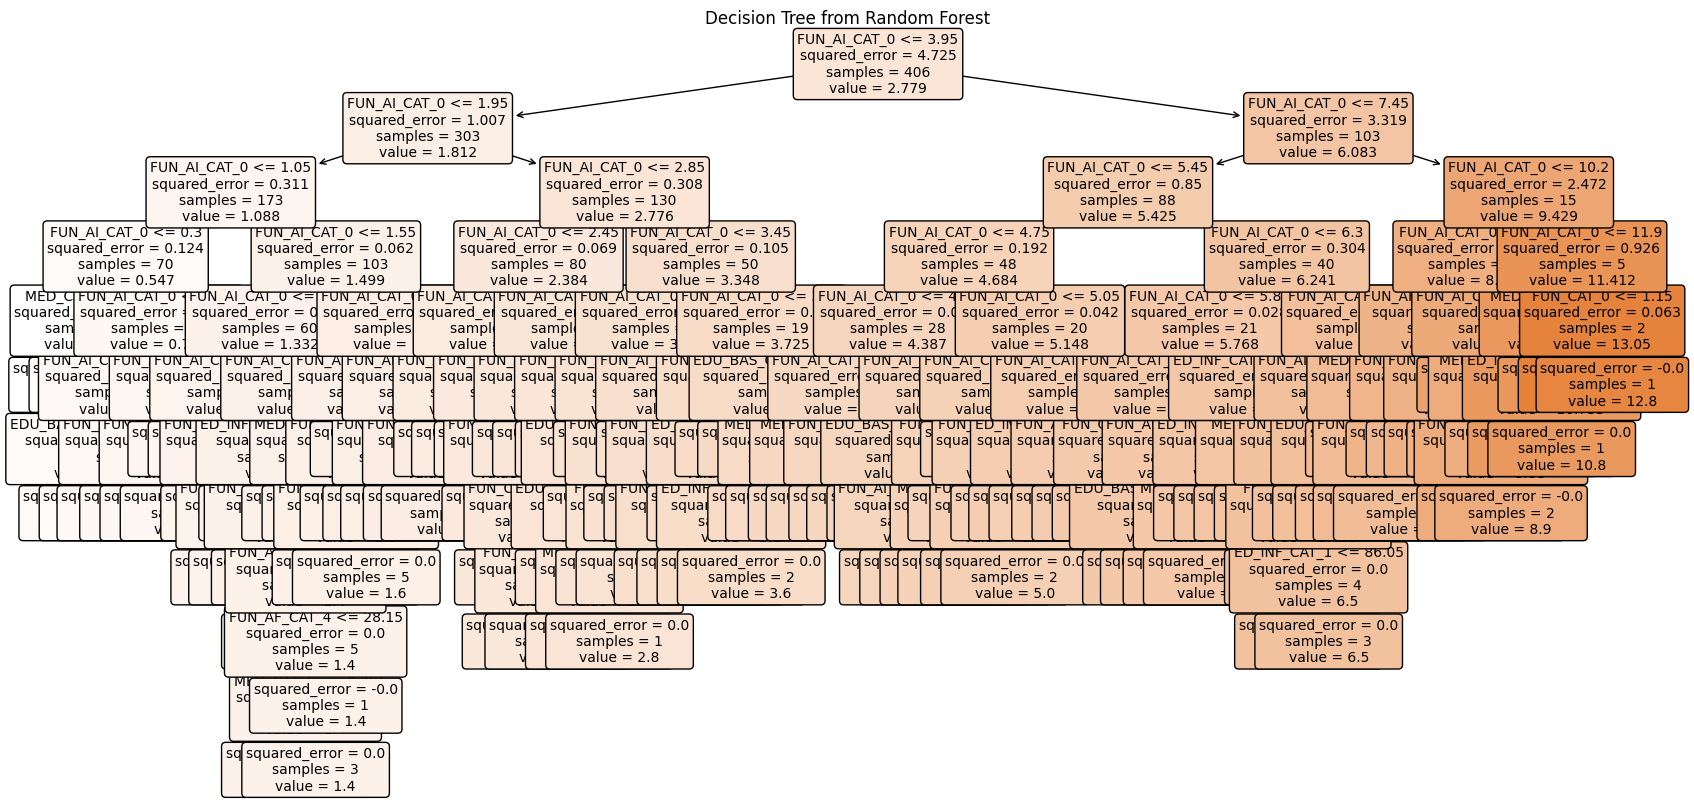

In [86]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
 
# Assuming regressor is your trained Random Forest model
# Pick one tree from the forest, e.g., the first tree (index 0)
tree_to_plot = regressor.estimators_[0]
 
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=trainning_df.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()

In [96]:
trainning_df.replace('--', np.nan, inplace=True)
X = trainning_df.drop('EVASAO_COLUMN_MED', axis=1).select_dtypes(exclude=['object']).values
y = trainning_df['EVASAO_COLUMN_MED']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



In [98]:
display(X_train)

array([[76.3,  0. , 16.4, ...,  1.3,  2.8,  1.1],
       [68.2,  0. , 28.8, ...,  0.8,  1. ,  0.7],
       [78.8,  0. , 21.2, ...,  0.5,  0.5,  0.4],
       ...,
       [68.4,  0. , 26.4, ...,  0.4,  2.7,  1.2],
       [87.8,  0. ,  7.3, ...,  0.4,  0.6,  0.3],
       [50.6,  0. , 20.6, ...,  0.4,  1.7,  1. ]])

In [99]:
rf = RandomForestRegressor(oob_score=True)
rf.fit(X_train, y_train)

RandomForestRegressor(oob_score=True)

In [100]:
y_pred = rf.predict(X_test)

In [101]:
oob_score = rf.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("RMSE: ", rmse)

Out-of-Bag Score: 0.7424414340861205
Mean Squared Error: 1.5579396124031015
R-squared: 0.5862527925815015
RMSE:  1.248


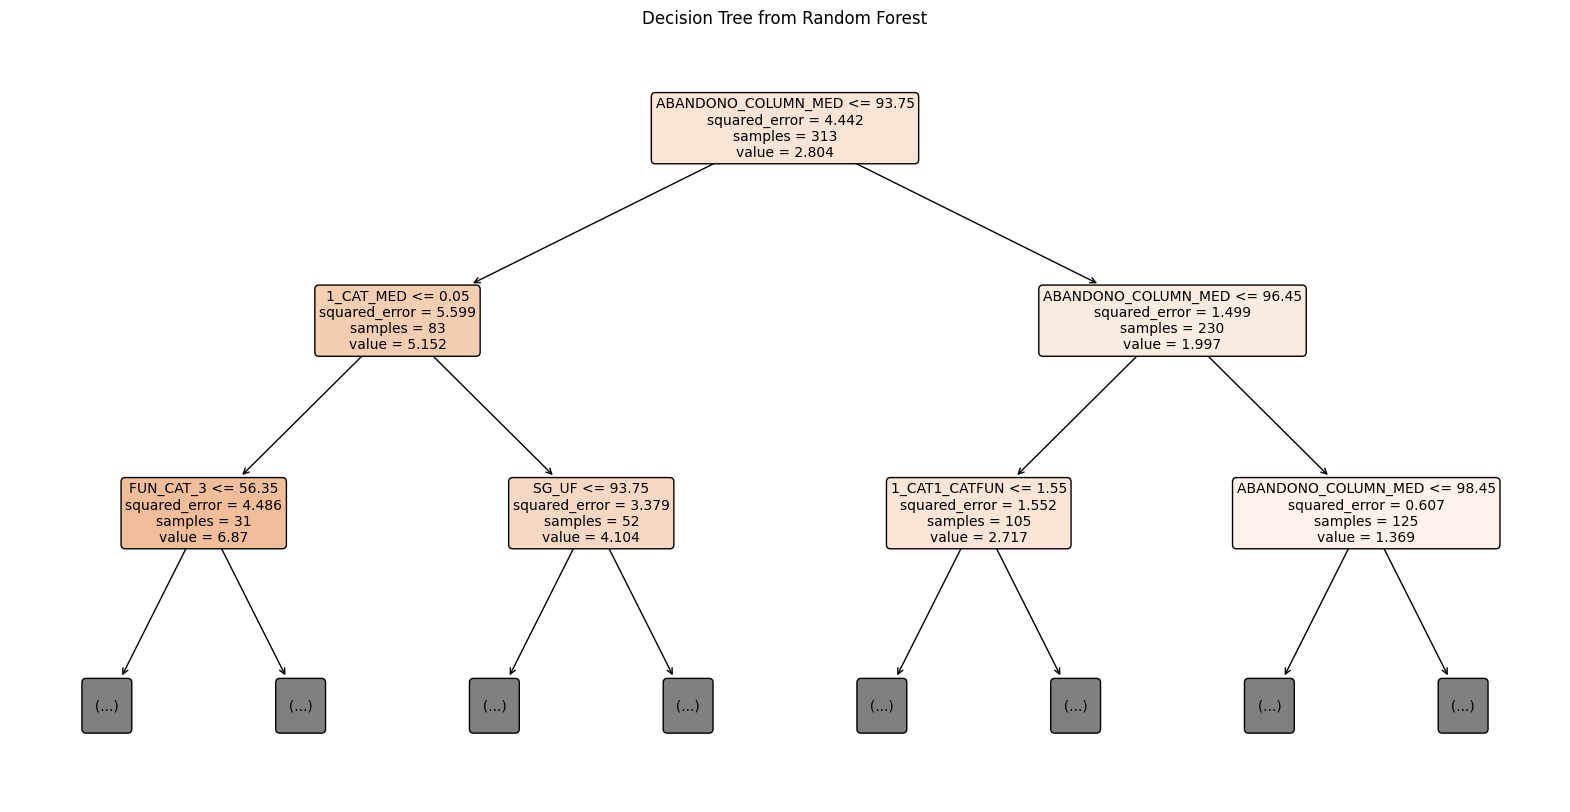

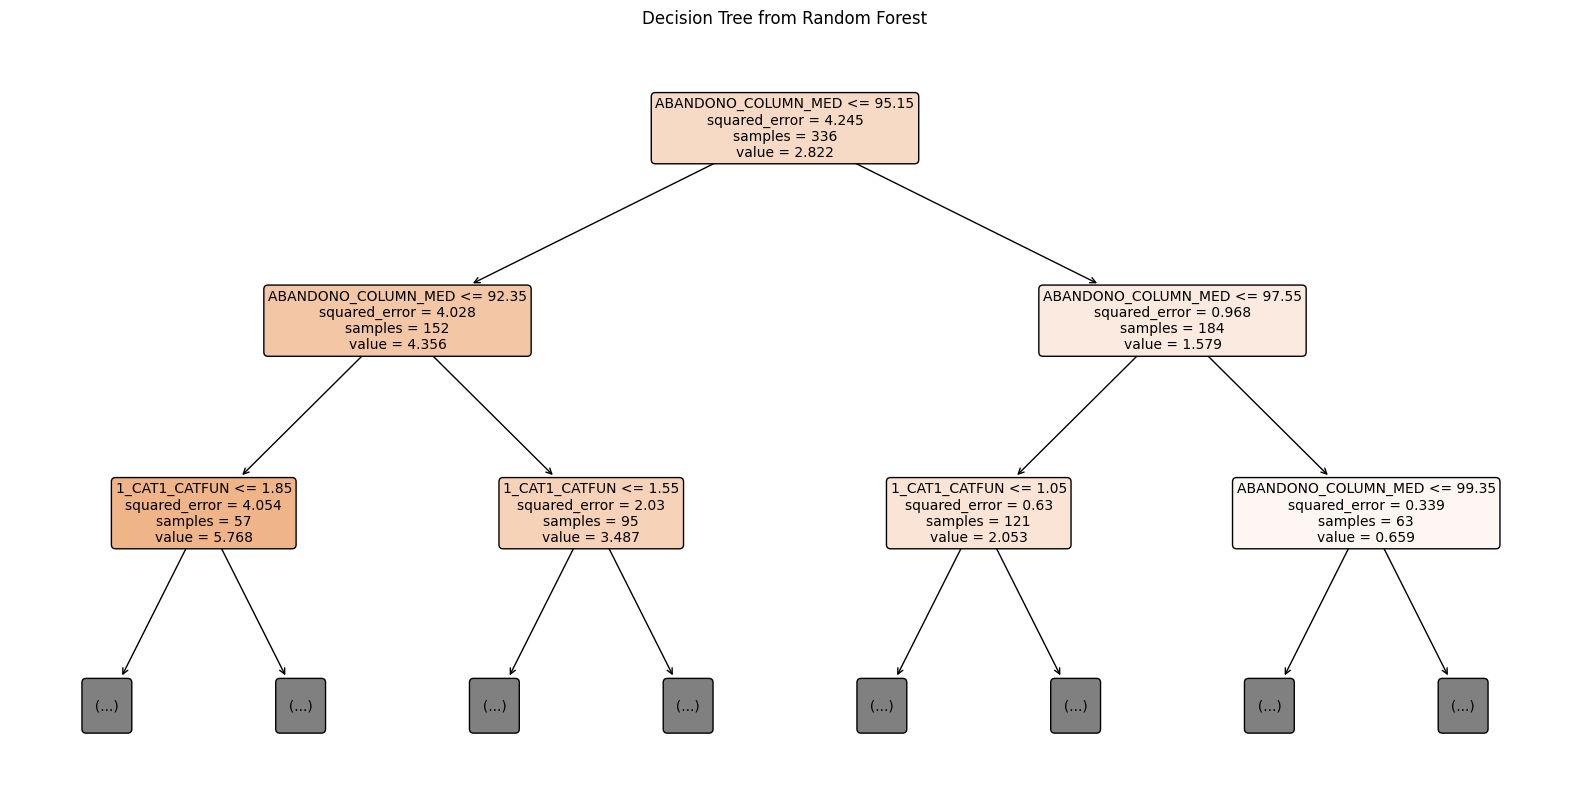

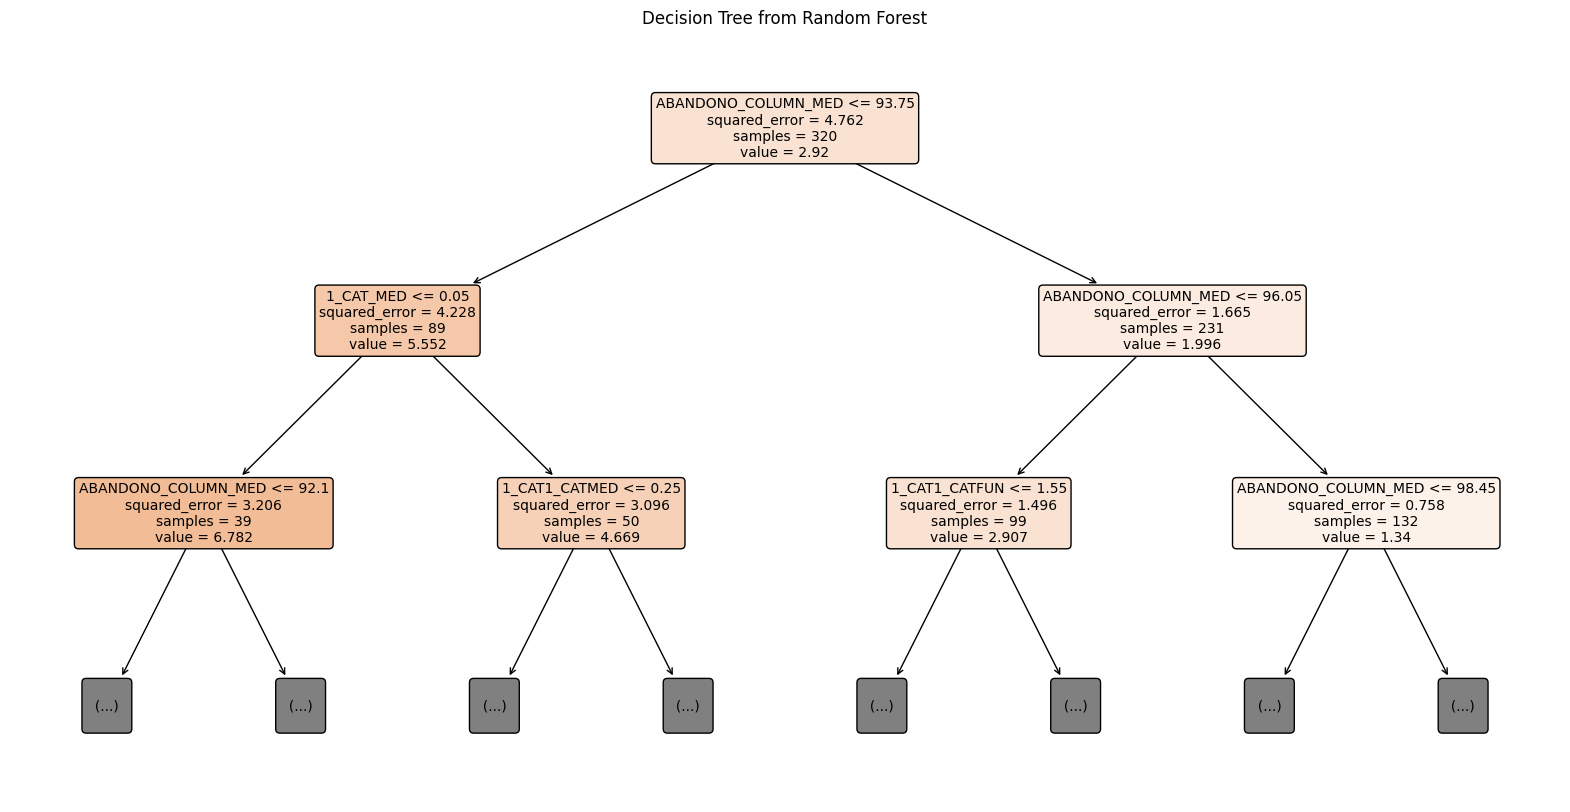

In [102]:
from sklearn.tree import plot_tree

for i in range(3):
    tree = rf.estimators_[i]
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=trainning_df.columns.tolist(), filled=True, rounded=True, fontsize=10, max_depth=2)
    plt.title("Decision Tree from Random Forest")
    plt.show()

<Axes: >

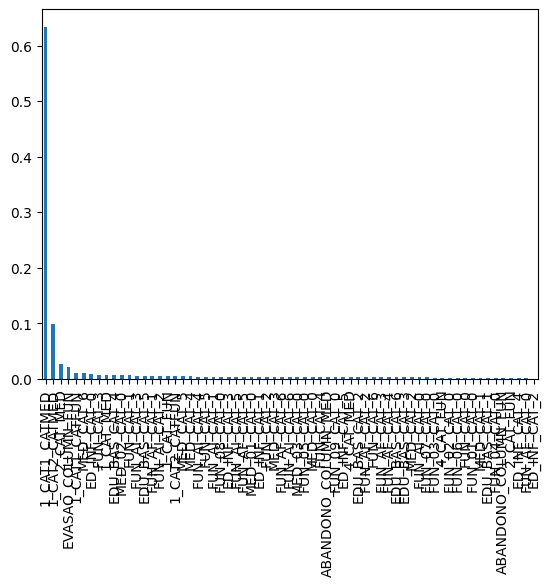

In [103]:
feature_importances = pd.Series(rf.feature_importances_, index=trainning_df.drop('EVASAO_COLUMN_MED', axis=1).select_dtypes(exclude=['object']).columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

In [104]:
param_dist = {'n_estimators': randint(1,500),
              'max_depth': randint(1,20)}

rf = RandomForestRegressor(oob_score=True)

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(oob_score=True),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022280E8C850>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000222FCFF63D0>})

In [105]:
best_rf = rand_search.best_estimator_

print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 14, 'n_estimators': 300}


In [106]:
oob_score = best_rf.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

y_pred = best_rf.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("RMSE: ", rmse)

Out-of-Bag Score: 0.7430914218720601
Mean Squared Error: 1.4646941881216116
R-squared: 0.6110162902125236
RMSE:  1.21


<Axes: >

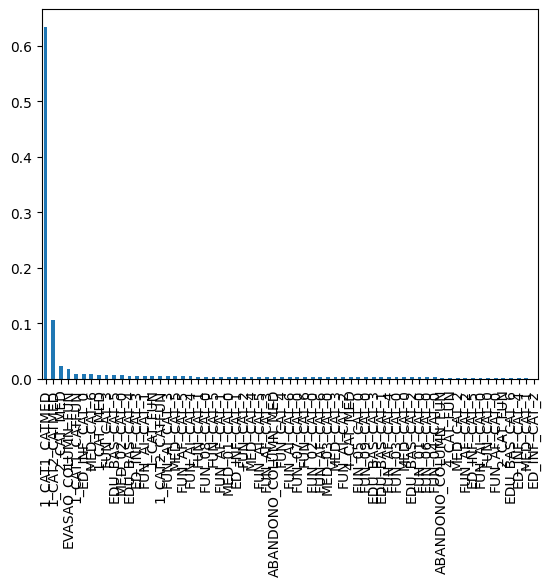

In [107]:
feature_importances = pd.Series(best_rf.feature_importances_, index=trainning_df.drop('EVASAO_COLUMN_MED', axis=1).select_dtypes(exclude=['object']).columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

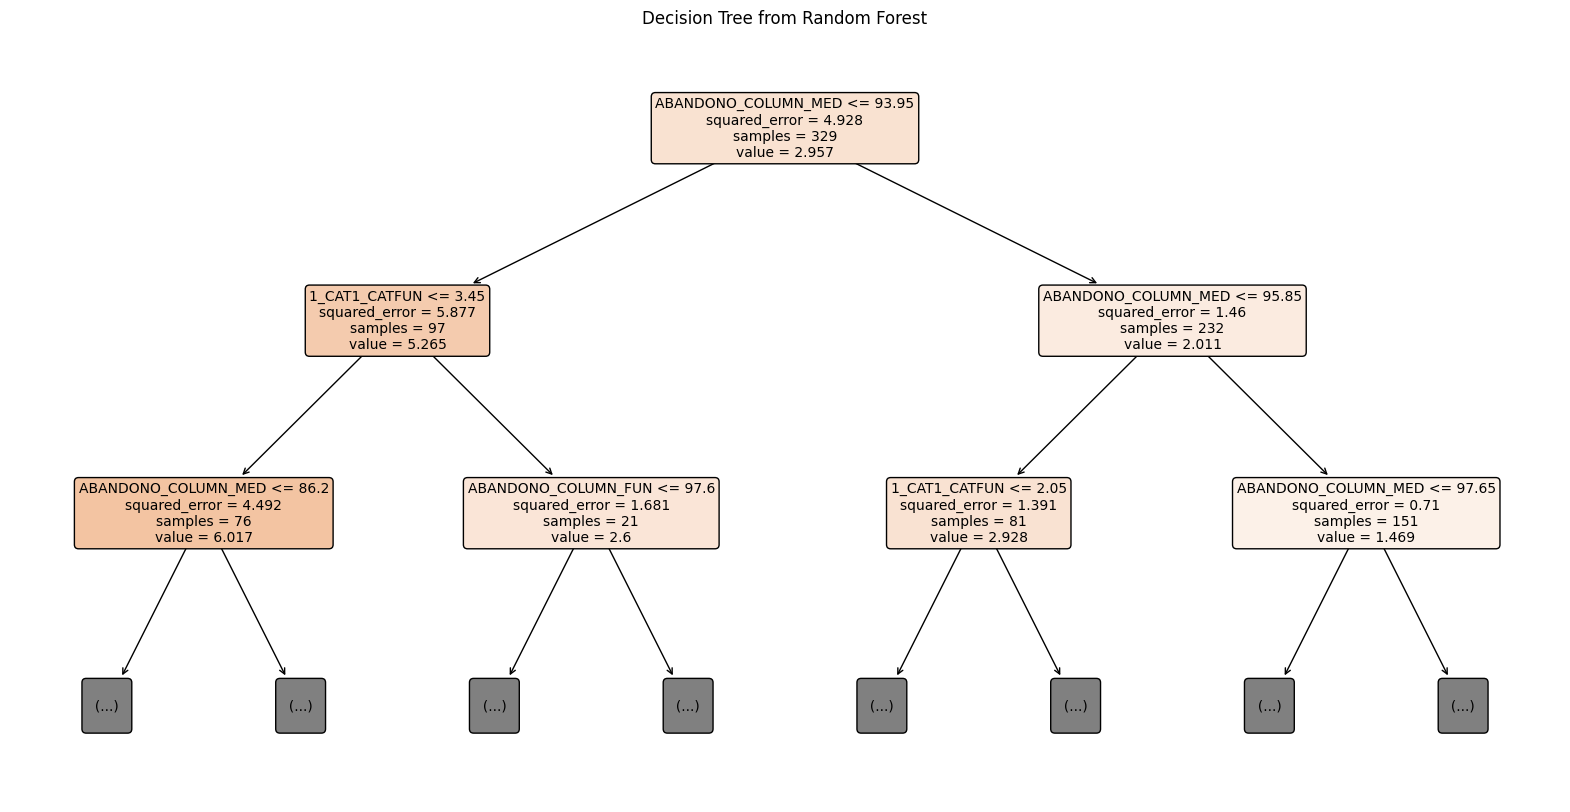

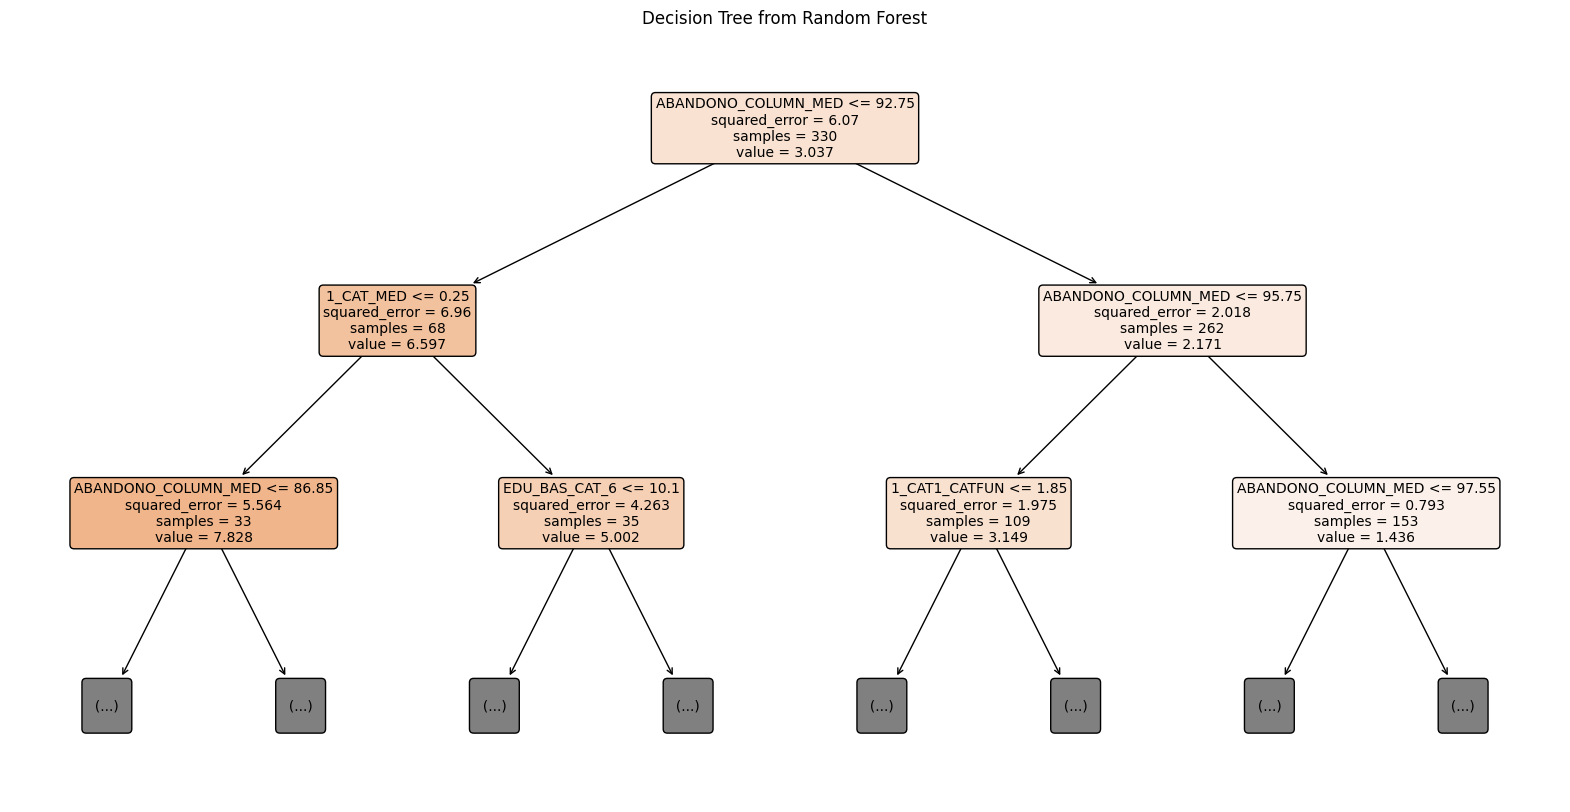

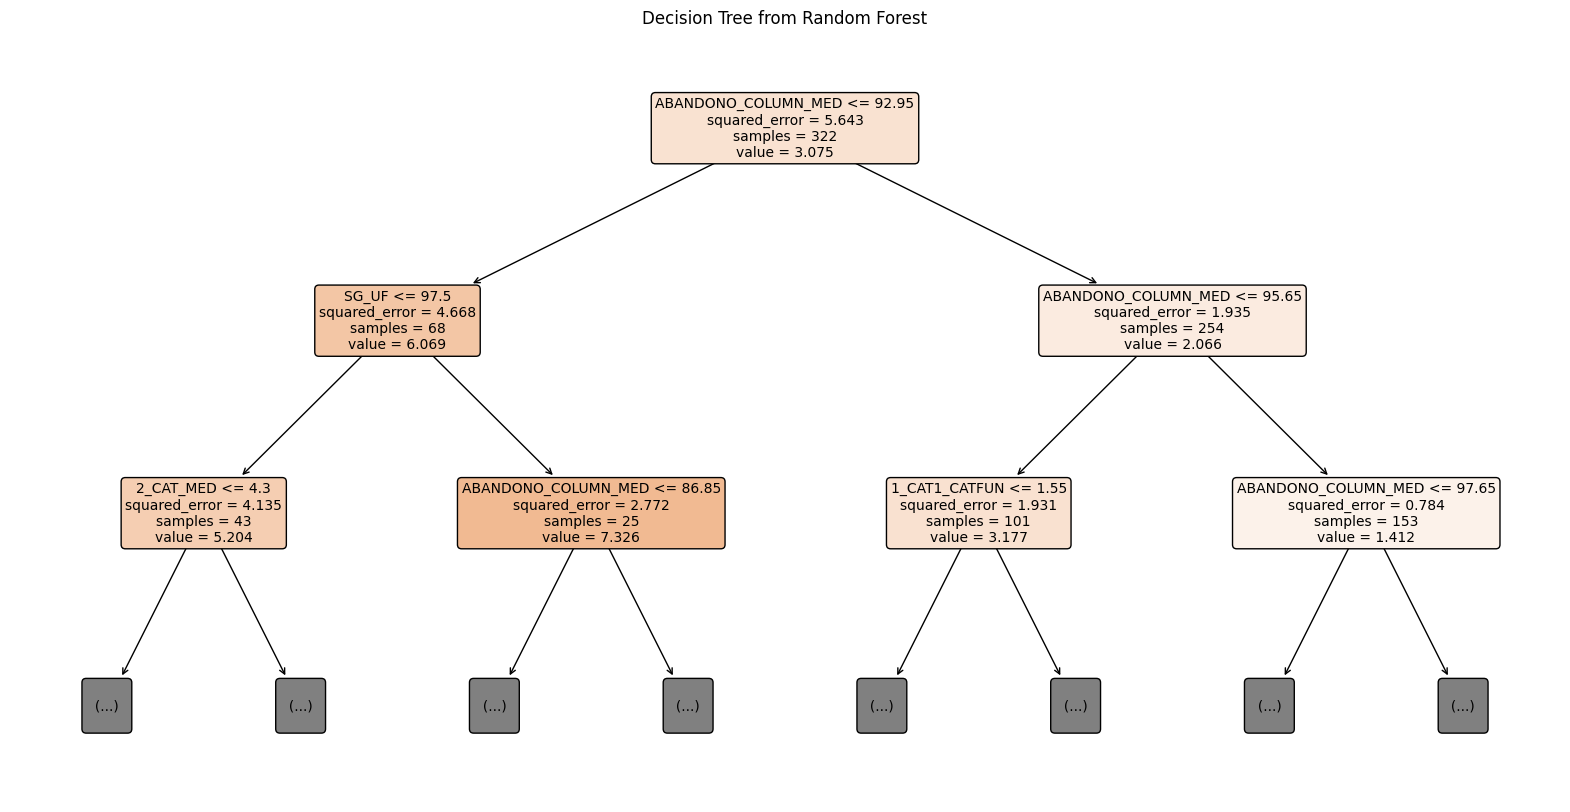

In [108]:
from sklearn.tree import plot_tree

for i in range(3):
    tree = best_rf.estimators_[i]
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=trainning_df.columns.tolist(), filled=True, rounded=True, fontsize=10, max_depth=2)
    plt.title("Decision Tree from Random Forest")
    plt.show()